In [2]:
import sys
print(sys.version)

3.6.5 (default, May 28 2018, 14:34:47) 
[GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.1)]


In [3]:
#
# emotions classification - coded up for fun just to give you some ideas
#

Motivation:
    
1) It may be useful for example to enhance human-robot interactions 

2) May be used to perform studies on behaviors on social media platofroms, and so on, ...

Dataset: 

Expanded Cohn-Kanabe (CK+) dataset:
small number of images, 640 x 400 pixels 
each labelled with one of the following 8 emotions: 

0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise


http://www.consortium.ri.cmu.edu/ckagree/


The deep methods usually work on big data samples. 

The problem of small dataset may be adressed in different ways:

1) add more examples,

2) another option is data augmentation. 

Emotion classification is an example of imbalanced label distribution 
because some classes of emotions are relatively rare comparing to other labels.

What options are there for data augmentation? 

1) geometric transformation which is relatively generic and computationally cheap: 
   generation of image data through label-preserving linear transformations (translation, rotation, scaling,    horizontal shearing) such as Affine, elastic deformations, patches extraction, and RGB channels intensities alteration

2) task-specific or guided-augmentation methods which are able to generate synthetic samples given specific labels

Of course, not all transformations have sense for the emotion classification. For example, the chances are
very slim that upside-down images will be used (but who knows, In the human-robot interaction case, a person who interacts with a robot may be standing on hands :) ) 

Interesting approach for data augmentation for emotion classifiers is presented here:
 
https://arxiv.org/abs/1711.00648 (cycle-consistent adversarial networks (CycleGAN) as the generator) 


https://github.com/SharonZhu/Data-augmentation-using-GAN



In [4]:
%matplotlib inline

import os
import sys
import numpy as np
import scipy.io
import scipy.misc
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from IPython.display import Image as Img
import glob, csv
import pandas as pd
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [4]:
imagePath = '/Users/tpalczew/CK+/cohn-kanade-images/S503/002/S503_002_00000005.png'

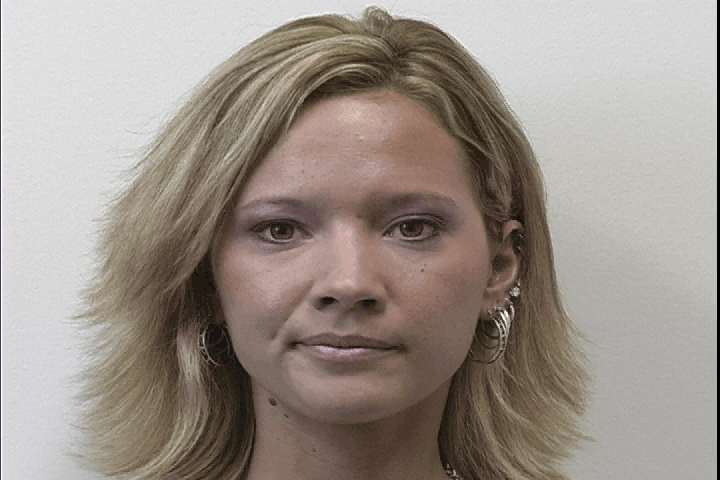

In [5]:
Img(filename = imagePath, width=200, height=200)

In [6]:
imagePath = '/Users/tpalczew/CK+/cohn-kanade-images/S999/003/S999_003_00000040.png'

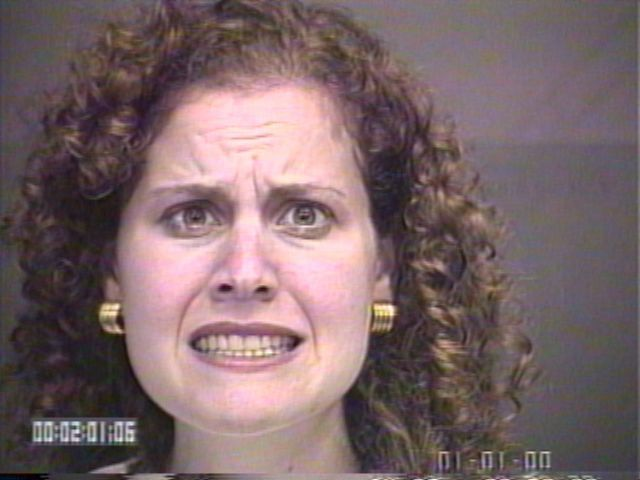

In [7]:
Img(filename = imagePath, width=200, height=200)

In [8]:
#
# Data augmentation - Minor changes such as flips or translations or rotations.
#

A convolutional neural network that can robustly classify objects even if 
they are placed in different orientations 
has a property called invariance. 

CNN can be invariant to translation, viewpoint, size, illumination (or a combination of the above)

In [9]:
#
# When? Before feeding Network. Two options:  
# 1) offline augmentation - perform all the necessary transformations beforehand
# 2) online augmentation (augmentation on the fly) - perform transformations on a mini-batch
#                                                    just before feeding it to your model
#

In [10]:
#
# Let's implement some kind of emotion classifiers from ~scratch:
# 

In [11]:
# algorithm options
batch_size = 128
epochs = 50

# input image dimensions
img_rows, img_cols = 28, 28

In [12]:
num_classes = 8
emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Emotion list

In [13]:
def importCKPlusDataset():
    categories = emotions
    
    dirImages = '/Users/tpalczew/CK+/cohn-kanade-images'
    dirLabels = '/Users/tpalczew/CK+/Emotion'
    
    imageFiles = glob.glob(dirImages + '/*/*/*.png')
    labelFiles = glob.glob(dirLabels + '/*/*/*.txt')
    
    allLabeledImages = []
   
    for label in labelFiles:
        img = label.replace(dirLabels,dirImages)
        img = img.replace('_emotion.txt','.png')
        
        allLabeledImages.append(img)
        
    labeledImages = []
    labels = []
    labelNames = []
    contemptImages = []
    
    for ind in range(len(labelFiles)):
        curLabel = labelFiles[ind]
        curImage = allLabeledImages[ind]
        
        with open(curLabel, 'r') as csvfile:
            rd = csv.reader(csvfile)
            str = next(rd)
            numCK = int(float(str[0]))
            # Get text label from CK+ number
            labelText = categories[numCK-1]
            
            if labelText != 'Contempt': 
                numEitW = categories.index(labelText)
                image = cv2.imread(curImage)
                image = cv2.resize(image, (img_rows, img_cols))
                image = img_to_array(image)
                labeledImages.append(image)
                labels.append(numEitW)
                labelNames.append(labelText)
    
    images = labeledImages
    return images, labels #, labelNames

In [14]:
images, labels = importCKPlusDataset()

images = np.array(images, dtype="float") / 255.0   # scale the raw pixel intensities to the range [0, 1]
labels = np.array(labels)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, random_state=42)

# convert the labels from integers to vectors
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


In [16]:
print(y_train)
print(len(y_train[1]))

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
8


In [17]:
print(x_train)
print(len(x_train))

print(x_train.shape)

[[[[0.00392157 0.00392157 0.00392157]
   [0.         0.         0.        ]
   [0.00392157 0.00392157 0.00392157]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.23921569 0.23921569 0.23921569]
   [0.30196078 0.30196078 0.30196078]
   [0.32156863 0.32156863 0.32156863]
   ...
   [0.41568627 0.41568627 0.41568627]
   [0.38431373 0.38431373 0.38431373]
   [0.34509804 0.34509804 0.34509804]]

  [[0.26666667 0.26666667 0.26666667]
   [0.30196078 0.30196078 0.30196078]
   [0.33333333 0.33333333 0.33333333]
   ...
   [0.43529412 0.43529412 0.43529412]
   [0.39215686 0.39215686 0.39215686]
   [0.35294118 0.35294118 0.35294118]]

  ...

  [[0.05098039 0.05098039 0.05098039]
   [0.8        0.8        0.8       ]
   [0.71764706 0.71764706 0.71764706]
   ...
   [0.09803922 0.09803922 0.09803922]
   [0.09803922 0.09803922 0.09803922]
   [0.23529412 0.23529412 0.23529412]]

  [[0.05098039 0.05098039 0.05098039]
   [0.0

In [18]:
print(len(x_test))
print(x_test)
print(y_test)

50
[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[0.70196078 0.70196078 0.70196078]
   [0.61960784 0.61960784 0.61960784]
   [0.78039216 0.78039216 0.78039216]
   ...
   [0.13333333 0.13333333 0.13333333]
   [0.0745098  0.0745098  0.0745098 ]
   [0.22352941 0.22352941 0.22352941]]

  [[0.67843137 0.67843137 0.67843137]
   [

In [19]:
print((y_test))
print(len(y_test))

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 

In [20]:
#
# define architecture
#

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28,28,3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(8))
model.add(Activation('softmax'))



In [21]:
# Complie model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [22]:
# Fit model
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 277 samples, validate on 50 samples
Epoch 1/50
277/277 [==============================] - 3s 12ms/step - loss: 2.5604 - acc: 0.1661 - val_loss: 2.5182 - val_acc: 0.2800
Epoch 2/50
277/277 [==============================] - 2s 7ms/step - loss: 1.4745 - acc: 0.4946 - val_loss: 2.9426 - val_acc: 0.3200
Epoch 3/50
277/277 [==============================] - 2s 7ms/step - loss: 0.8410 - acc: 0.7617 - val_loss: 2.4819 - val_acc: 0.2800
Epoch 4/50
277/277 [==============================] - 2s 7ms/step - loss: 0.5003 - acc: 0.8628 - val_loss: 2.4101 - val_acc: 0.3200
Epoch 5/50
277/277 [==============================] - 2s 6ms/step - loss: 0.3525 - acc: 0.9134 - val_loss: 1.9129 - val_acc: 0.3600
Epoch 6/50
277/277 [==============================] - 1s 5ms/step - loss: 0.2443 - acc: 0.9675 - val_loss: 2.2664 - val_acc: 0.2800
Epoch 7/50
277/277 [==============================] - 1s 5ms/step - loss: 0.1727 - acc: 0.9783 - val_loss: 1.9328 - val_acc: 0.3800
Epoch 8/50
277/277 [==========

In [23]:
# Score
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.9261497783660888
Test accuracy: 0.36000000953674316


In [24]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


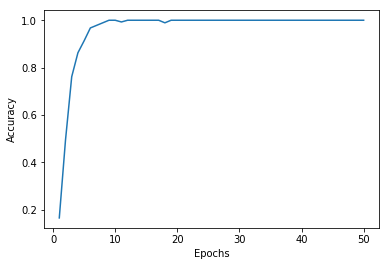

In [25]:
plt.plot(range(1,51), history.history['acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

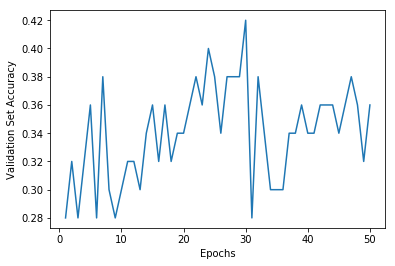

In [26]:
plt.plot(range(1,51), history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Validation Set Accuracy')
plt.show()

In [27]:
# data augmentation 

In [28]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=35,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True)

In [29]:
datagen.fit(x_train)

In [30]:
# fits the model on batches with real-time data augmentation:
history2 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=epochs)

Epoch 1/50
9/8 [===============================] - 2s 172ms/step - loss: 2.5174 - acc: 0.2241
Epoch 2/50
9/8 [===============================] - 1s 166ms/step - loss: 2.3858 - acc: 0.2397
Epoch 3/50
9/8 [===============================] - 2s 168ms/step - loss: 2.2294 - acc: 0.2192
Epoch 4/50
9/8 [===============================] - 2s 170ms/step - loss: 2.1829 - acc: 0.2506
Epoch 5/50
9/8 [===============================] - 1s 166ms/step - loss: 2.0356 - acc: 0.2485
Epoch 6/50
9/8 [===============================] - 1s 167ms/step - loss: 2.0565 - acc: 0.2694
Epoch 7/50
9/8 [===============================] - 2s 168ms/step - loss: 1.9543 - acc: 0.3010
Epoch 8/50
9/8 [===============================] - 2s 168ms/step - loss: 1.9081 - acc: 0.2873
Epoch 9/50
9/8 [===============================] - 2s 169ms/step - loss: 1.8775 - acc: 0.2957
Epoch 10/50
9/8 [===============================] - 2s 168ms/step - loss: 1.8048 - acc: 0.3322
Epoch 11/50
9/8 [===============================] - 2s 169m

In [31]:
# Score
score2 = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Test loss: 2.24403489112854
Test accuracy: 0.1800000001490116


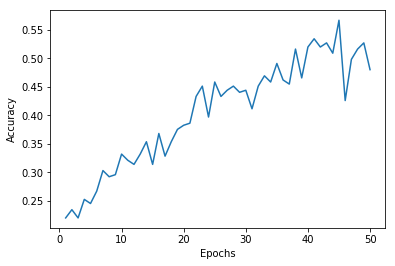

In [32]:
plt.plot(range(1,51), history2.history['acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [33]:
y_pred_keras = model.predict(x_test).ravel()
y_pred_keras = np.reshape(y_pred_keras, (-1, 8))

In [34]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_keras[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/usr/local/var/pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


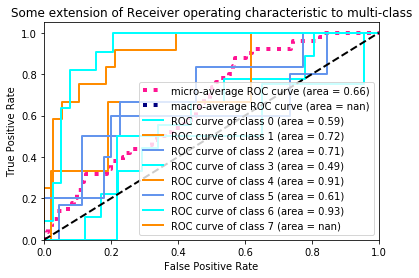

In [35]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_keras.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [36]:
#
# Confusion Matrix
#

#print(y_pred_keras.shape)
#print(y_test.shape)

pred_list = []
actual_list = []

for i in y_pred_keras:
    pred_list.append(np.argmax(i))

for i in y_test:
    actual_list.append(np.argmax(i))
    
confm = confusion_matrix(actual_list, pred_list)
print(confm)

[[0 6 2 0 1 0 0]
 [0 2 1 0 0 0 0]
 [0 4 2 0 0 0 0]
 [0 3 0 0 1 0 0]
 [0 3 4 0 5 0 0]
 [0 4 1 0 0 0 0]
 [0 9 1 1 0 0 0]]


In [37]:
#
# the test is so small that we don't have any "surprise" examples
#

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            try:
                rowdata[col_label]=cm[i,j]
            except:
                rowdata[col_label]=0
                
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

labels = emotions
cm2df(confm, labels)

neutral  anger  contempt  disgust  fear  happy  sadness  surprise
neutral         0      6         2        0     1      0        0         0
anger           0      2         1        0     0      0        0         0
contempt        0      4         2        0     0      0        0         0
disgust         0      3         0        0     1      0        0         0
fear            0      3         4        0     5      0        0         0
happy           0      4         1        0     0      0        0         0
sadness         0      9         1        1     0      0        0         0
surprise        0      0         0        0     0      0        0         0

In [38]:
# we could see this on the ROC curve that somehow ROC curve of class 6 
# had high TPR with resonable FPR, of course I doesn't mean anything as the set is too small 

In [39]:
#
# Let's imagine that we had larger dataset, we learnt everything, 
# and from accuracy, precission, recall, ROC curves, confusion matrix, and other tests 
# we see that everything is ok 
# If this would be the case, we could now start using this emotion classifier :) 
#

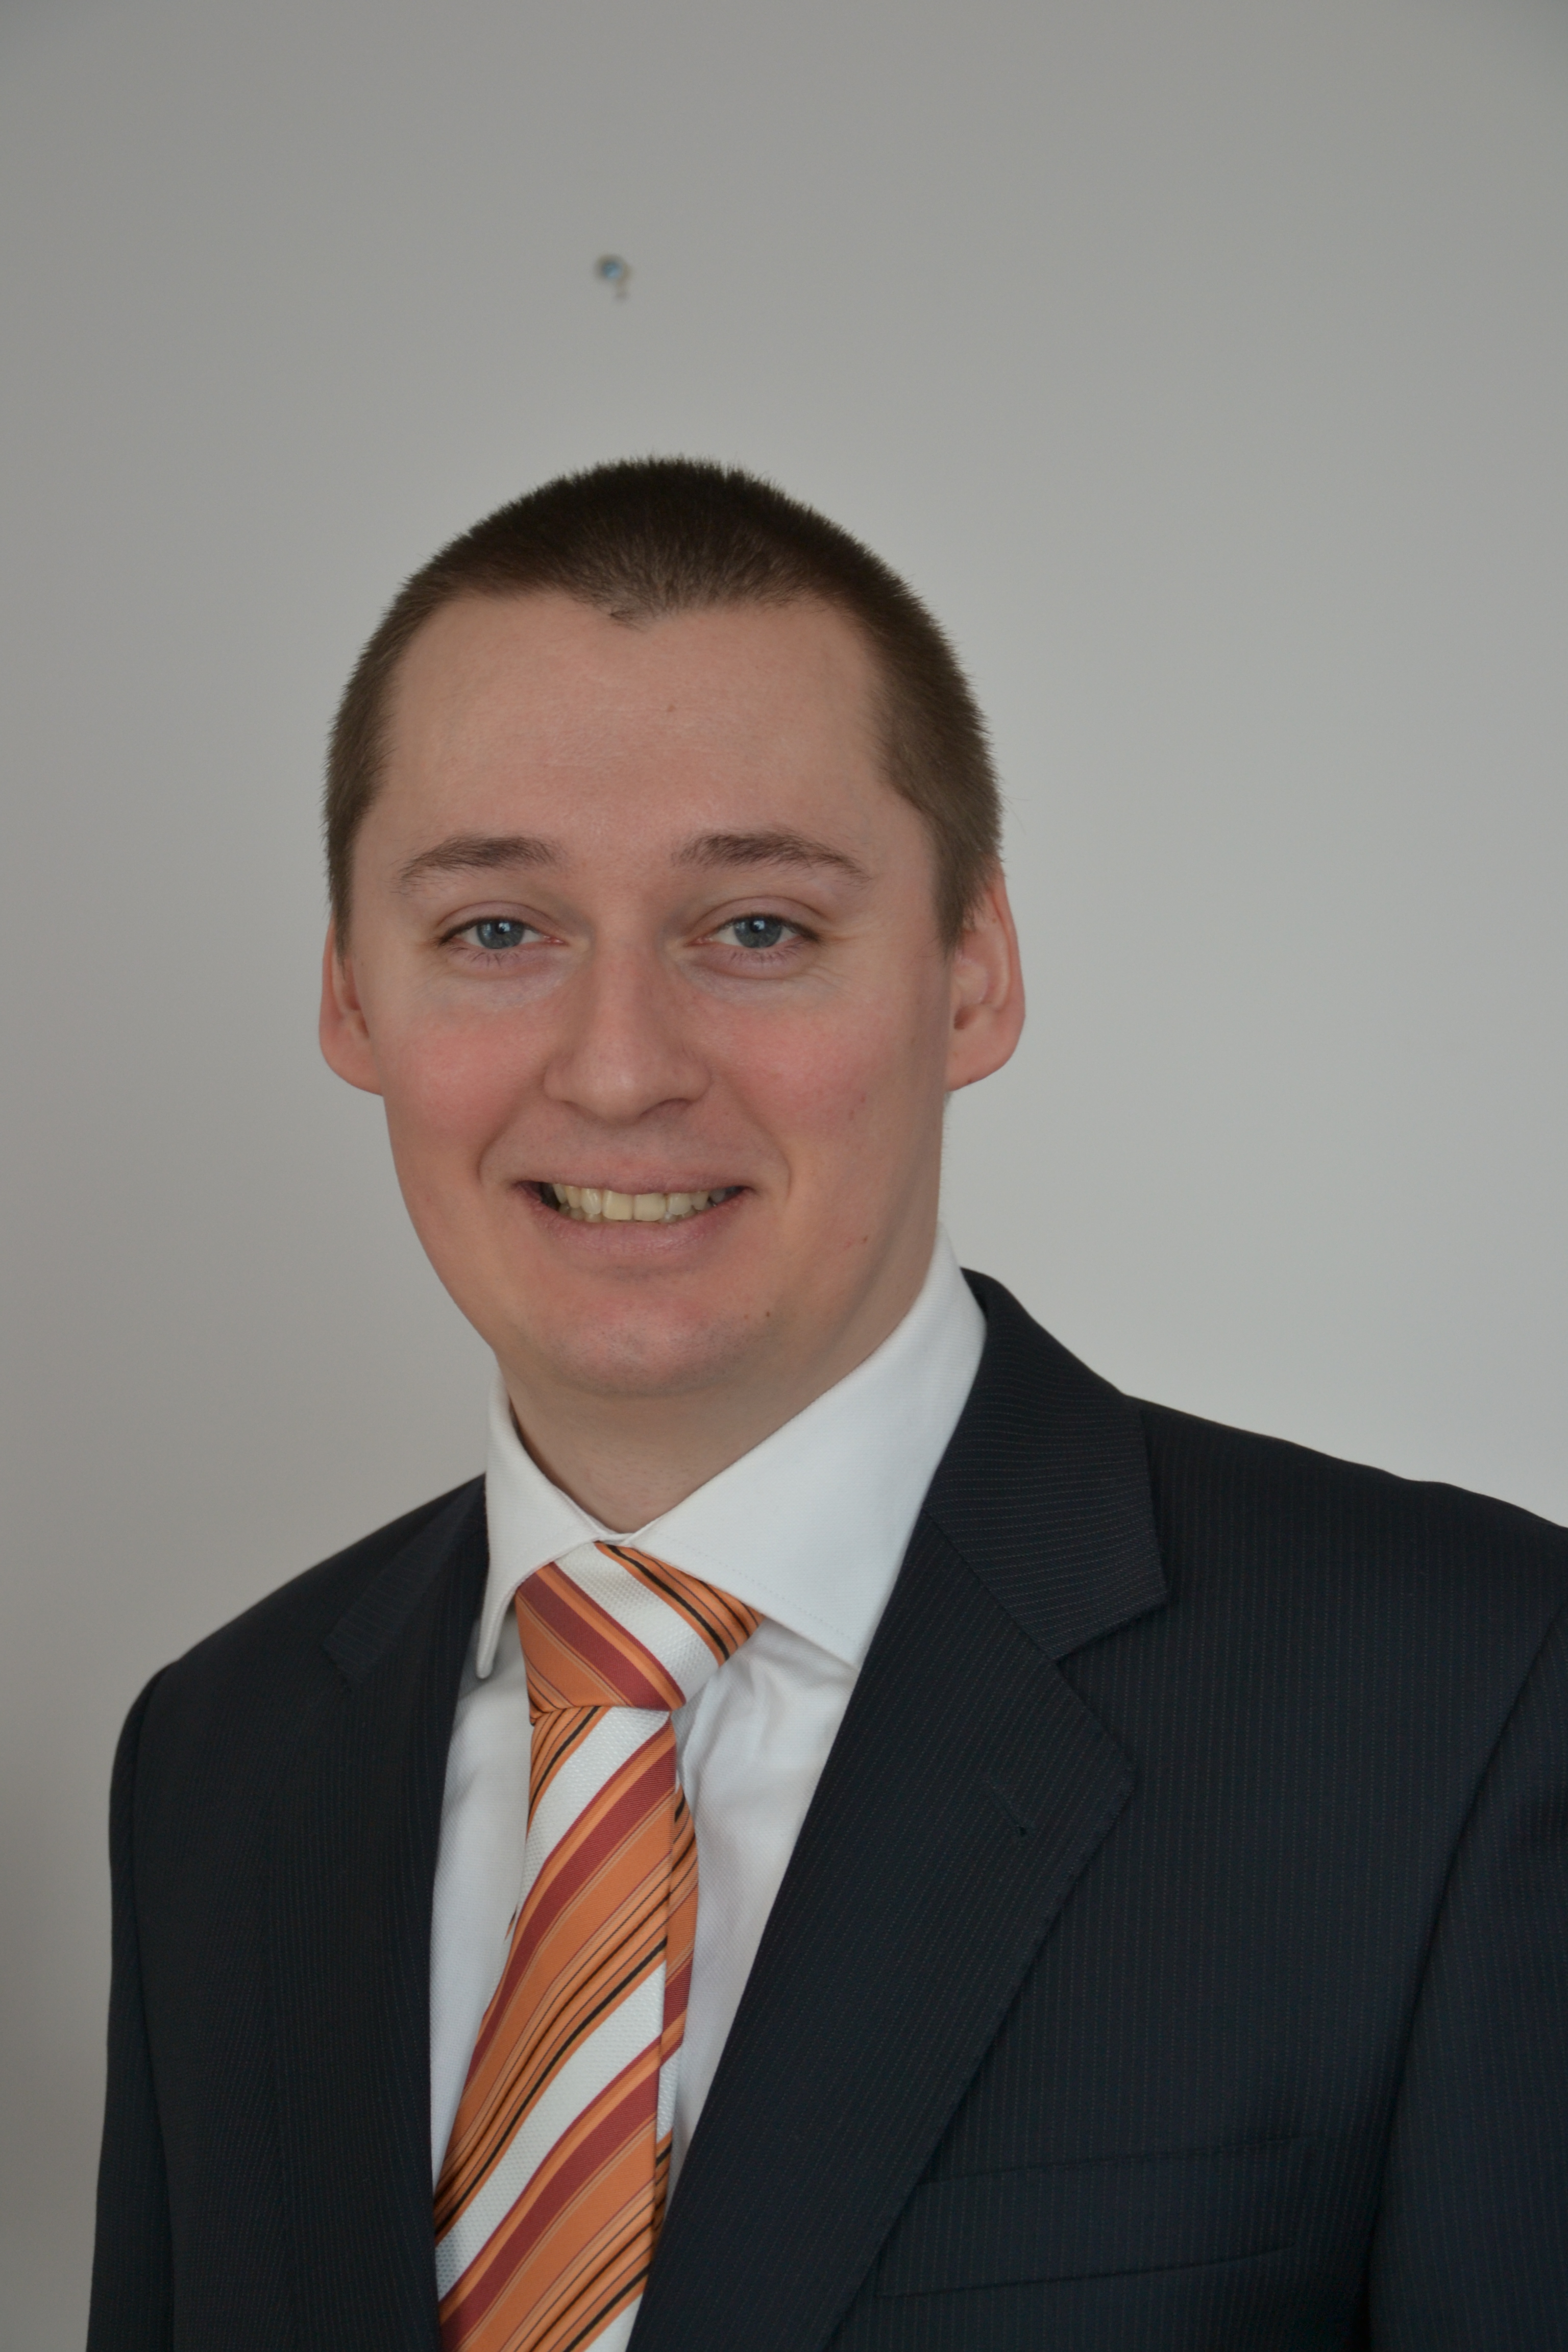

In [40]:
img = "/Users/tpalczew/SomePhotos/DSC_007.JPG"

Img(filename = img, width=200, height=200)

(1, 28, 28, 3)
[6.9338299e-02 8.1348252e-01 3.4214839e-02 5.4135226e-02 1.0213486e-02
 3.3985346e-03 1.5215147e-02 1.9930767e-06]


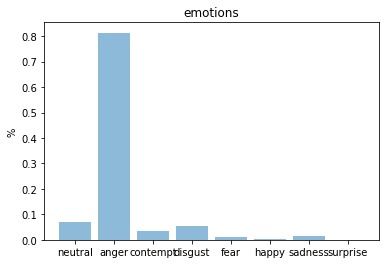

<Figure size 432x288 with 0 Axes>

In [41]:
image = cv2.imread(img)
image = cv2.resize(image, (img_rows, img_cols))
image = img_to_array(image)

image = np.array(image, dtype="float") / 255.0 

image = np.expand_dims(image, axis=0) 

print(image.shape)

custom = model.predict(image).ravel()
print(custom)

y_pos = np.arange(len(emotions))

plt.bar(y_pos, custom, align='center', alpha=0.5)

plt.xticks(y_pos, emotions)

plt.ylabel('%')

plt.title('emotions')

plt.show()

image = np.array(image, 'float32')
plt.gray()
plt.show()

In [42]:
#
# can we get more training examples?
#
# https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
#
# 48x48 pixel grayscale images of faces
# 28,709 examples - (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
#

In [8]:
with open("/Users/tpalczew/fer2013/fer2013.csv") as f:
    content = f.readlines()
    lines = np.array(content)
    print(lines)
    num_of_instances = lines.size
    print("number of instances: ",num_of_instances)

['emotion,pixels,Usage\n'
 '0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200

In [9]:
x, y = [], []

for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
        val = img.split(" ")
        pixels = np.array(val, 'float32')
        emotion = keras.utils.to_categorical(emotion, num_classes)
        x.append(pixels)
        y.append(emotion)
    except:
        print("", end="")

x = np.array(x)
y = np.array(y)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [46]:
print(x_train.shape)

(28709, 2304)


In [47]:
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')

x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

x_train/=255
x_test/=255

In [48]:
#
# define architecture
#

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(48,48,1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(8))
model.add(Activation('softmax'))

#--

# Complie model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [49]:
# Fit model
history3 = model.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=5,
           verbose=1,
           validation_data=(x_test, y_test))

Train on 28709 samples, validate on 7178 samples
Epoch 1/5
28709/28709 [==============================] - 558s 19ms/step - loss: 1.5732 - acc: 0.4176 - val_loss: 2.2057 - val_acc: 0.2796
Epoch 2/5
28709/28709 [==============================] - 530s 18ms/step - loss: 1.2041 - acc: 0.5442 - val_loss: 1.6961 - val_acc: 0.3888
Epoch 3/5
28709/28709 [==============================] - 530s 18ms/step - loss: 1.0041 - acc: 0.6256 - val_loss: 1.7238 - val_acc: 0.4380
Epoch 4/5
28709/28709 [==============================] - 528s 18ms/step - loss: 0.8164 - acc: 0.6998 - val_loss: 1.5347 - val_acc: 0.5149
Epoch 5/5
28709/28709 [==============================] - 529s 18ms/step - loss: 0.6340 - acc: 0.7716 - val_loss: 1.6195 - val_acc: 0.5153


In [50]:
# Score
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.619537858386397
Test accuracy: 0.5153246029534689


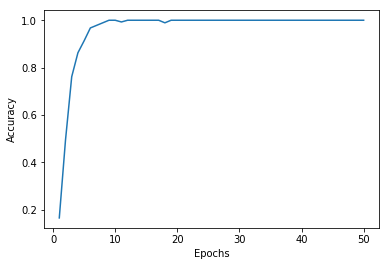

In [51]:
plt.plot(range(1,51), history.history['acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [19]:
#
# What about transfer learning? maybe it's worth trying if you don't have enough data 
# 
#
# http://www.yugangjiang.info/publication/icmr16-emotion.pdf
#
# "The result of VGG-19 is a little lower than VGG-16, 
# which demonstrates that deeper networks may not be appropriate for the emotion recognition task"
#
#

https://arxiv.org/pdf/1709.01688.pdf

https://arxiv.org/pdf/1709.01688.pdf    

http://vintage.winklerbros.net/Publications/emotiw2015.pdf

http://ambientintelligence.aalto.fi/theses/Strengell_BSc.pdf

Idea: Use previously trained convolutional network, and build on top of that

Pretrained models http://www.vlfeat.org/matconvnet/pretrained/#imagenet-ilsvrc-classification

Let's take vgg19 

VGG-VD models from the Very Deep Convolutional Networks for Large-Scale Visual Recognition project.

"Very Deep Convolutional Networks for Large-Scale Image Recognition", Karen Simonyan and Andrew Zisserman, arXiv technical report, 2014.

In [20]:
vgg_name = 'vgg-19'
path = "/Users/tpalczew/imagenet-vgg-verydeep-19.mat"
vgg = scipy.io.loadmat(path)

In [21]:
vgg_layers = vgg['layers']
print(vgg_layers)

[[array([[(array(['conv1_1'], dtype='<U7'), array(['conv'], dtype='<U4'), array([[array([[[[ 0.39416704, -0.08419707, -0.03631314, ..., -0.10720515,
          -0.03804016,  0.04690642],
         [ 0.46418372,  0.03355668,  0.10245045, ..., -0.06945956,
          -0.04020201,  0.04048637],
         [ 0.34119523,  0.09563112,  0.0177449 , ..., -0.11436455,
          -0.05099866, -0.00299793]],

        [[ 0.37740308, -0.07876257, -0.04775979, ..., -0.11827433,
          -0.19008617, -0.01889699],
         [ 0.41810837,  0.05260524,  0.09755926, ..., -0.09385028,
          -0.20492788, -0.0573062 ],
         [ 0.33999205,  0.13363543,  0.02129423, ..., -0.13025227,
          -0.16508926, -0.06969624]],

        [[-0.04594866, -0.11583115, -0.14462094, ..., -0.12290562,
          -0.35782176, -0.27979308],
         [-0.04806903, -0.00658076, -0.02234544, ..., -0.0878844 ,
          -0.3915486 , -0.34632796],
         [-0.04484424,  0.06471398, -0.07631404, ..., -0.12629718,
          -0.29

Now let's produce model graph. The max pooling layers are replaced with the average pooling layers as the paper suggests. The fully connected layers are discarded. You can check ConvNet model's architecture online here: 

For vgg16 - http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-16.svg

For vgg19 - http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.svg


In [22]:
class CONFIG:
    IMAGE_WIDTH = 800
    IMAGE_HEIGHT = 600
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))


def make_graph(vgg, vgg_layers, name):
    #
    # based on the exercise from Coursera's Art Generation with Neural Style Transfer - v2
    #
    vgg = vgg
    vgg_layers = vgg_layers
    name = name
    #
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        W = vgg_layers[0][layer][0][0][2][0][0]
        b = vgg_layers[0][layer][0][0][2][0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        print({'layer name':layer_name, 'expected_layer_name':expected_layer_name})
        assert layer_name == expected_layer_name
        return W, b
    
    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)
    
    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(
            prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b
    
    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))
    
    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    if name == 'vgg-19':
        #
        # Constructs the graph model.
        graph = {}
        graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
        graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
        graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
        graph['avgpool1'] = _avgpool(graph['conv1_2'])
        graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
        graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
        graph['avgpool2'] = _avgpool(graph['conv2_2'])
        graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
        graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
        graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
        graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
        graph['avgpool3'] = _avgpool(graph['conv3_4'])
        graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
        graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
        graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
        graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
        graph['avgpool4'] = _avgpool(graph['conv4_4'])
        graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
        graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
        graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
        graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
        graph['avgpool5'] = _avgpool(graph['conv5_4'])
    if name == 'vgg-16':
        # Constructs the graph model.
        graph = {}
        graph['input']   = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
        graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
        graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
        graph['avgpool1'] = _avgpool(graph['conv1_2'])
        graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
        graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
        graph['avgpool2'] = _avgpool(graph['conv2_2'])
        graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
        graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
        graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
        graph['avgpool3'] = _avgpool(graph['conv3_3'])
        graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
        graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
        graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
        graph['avgpool4'] = _avgpool(graph['conv4_3'])
        graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
        graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
        graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
        graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
        graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph


In [23]:
graph_vgg19 = make_graph(vgg, vgg_layers, vgg_name)

{'layer name': 'conv1_1', 'expected_layer_name': 'conv1_1'}
{'layer name': 'conv1_2', 'expected_layer_name': 'conv1_2'}
{'layer name': 'conv2_1', 'expected_layer_name': 'conv2_1'}
{'layer name': 'conv2_2', 'expected_layer_name': 'conv2_2'}
{'layer name': 'conv3_1', 'expected_layer_name': 'conv3_1'}
{'layer name': 'conv3_2', 'expected_layer_name': 'conv3_2'}
{'layer name': 'conv3_3', 'expected_layer_name': 'conv3_3'}
{'layer name': 'conv3_4', 'expected_layer_name': 'conv3_4'}
{'layer name': 'conv4_1', 'expected_layer_name': 'conv4_1'}
{'layer name': 'conv4_2', 'expected_layer_name': 'conv4_2'}
{'layer name': 'conv4_3', 'expected_layer_name': 'conv4_3'}
{'layer name': 'conv4_4', 'expected_layer_name': 'conv4_4'}
{'layer name': 'conv5_1', 'expected_layer_name': 'conv5_1'}
{'layer name': 'conv5_2', 'expected_layer_name': 'conv5_2'}
{'layer name': 'conv5_3', 'expected_layer_name': 'conv5_3'}
{'layer name': 'conv5_4', 'expected_layer_name': 'conv5_4'}


In [ ]:
# to be continued